In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [3]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

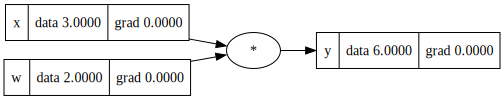

In [4]:
#Our old friend from the other example 2*x = y!

w = Value(2.0, label='w')
x = Value(3.0, label='x')
y = w*x; y.label = 'y'
draw_dot(y)

In [5]:
w = Value(2.0, label='w')
x = Value(3.0, label='x')
c = Value(10.0, label='c')

#This is the forward pass
y = w*x; y.label = 'y'
d = y + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label='L'

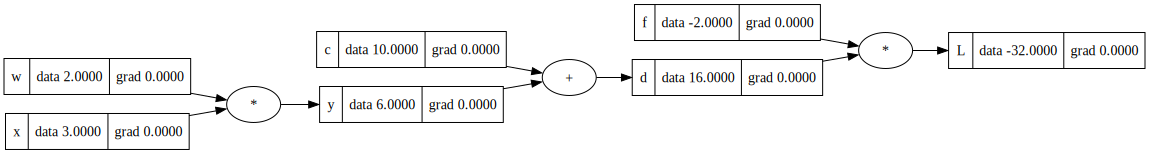

In [6]:
draw_dot(L)

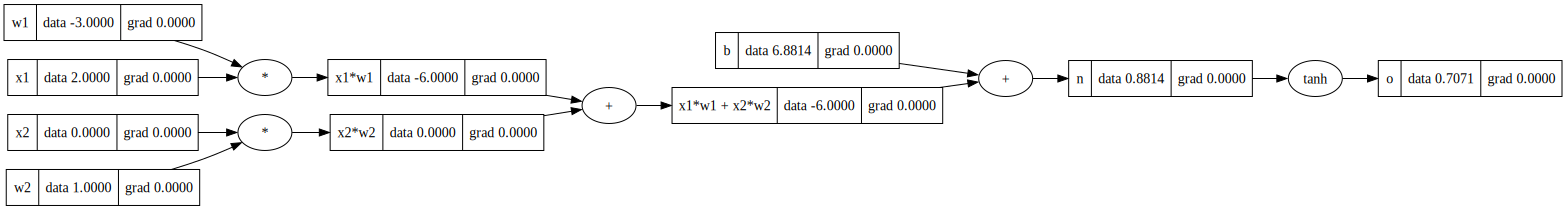

In [7]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

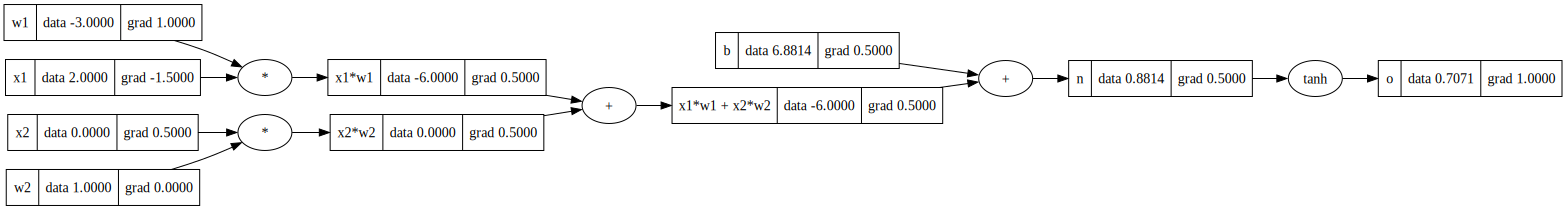

In [8]:
o.backward()
draw_dot(o)

# Neuron Class


In [9]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


  def __str__(self):
    res = ""
    for i, layer in enumerate(self.layers):
      res += f"Layer {i+1}:\n"
      for j, neuron in enumerate(layer.neurons):
        res += f"  Neuron {j+1}: {neuron(x).data}\n"
    return res

In [10]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.10210689485958223)

In [11]:
#lets see what this looks like before we train it

original_weights = n.__str__()

print(original_weights)

Layer 1:
  Neuron 1: 0.9048109900527556
  Neuron 2: 0.9853102664836743
  Neuron 3: 0.9987002215377083
  Neuron 4: 0.8407542006841692
Layer 2:
  Neuron 1: -0.06359691607907624
  Neuron 2: 0.9474007606296935
  Neuron 3: -0.9850139030938381
  Neuron 4: 0.9939222344952584
Layer 3:
  Neuron 1: -0.5196618567742487



In [12]:
#this is the training data, it's a list of (x,y) pairs

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

## Below is the actual code for updating weights after computing the graidents with backprobagation

In [13]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 3.5188111551324903
1 2.0378545576006704
2 0.5511348589573191
3 0.08285013704659507
4 0.06275198825735484
5 0.050655640311132955
6 0.042538182271696756
7 0.03670281305769306
8 0.03230173832143397
9 0.02886220548063914
10 0.026099155132776435
11 0.023830266318096864
12 0.02193341325514494
13 0.020323682883182835
14 0.018940190354265488
15 0.017738135737848913
16 0.016683819315700968
17 0.015751403690423896
18 0.014920747350306317
19 0.01417591737780606


In [14]:
#now lets print it again after the changes have been made

new_weights = n.__str__()
print("New Weights")
print(new_weights)


New Weights
Layer 1:
  Neuron 1: 0.9125276213219375
  Neuron 2: 0.9812775258280695
  Neuron 3: 0.9928238465954279
  Neuron 4: 0.7606723381008292
Layer 2:
  Neuron 1: -0.709946374389872
  Neuron 2: 0.8665917229467357
  Neuron 3: -0.9918509108943863
  Neuron 4: 0.9877382266575324
Layer 3:
  Neuron 1: 0.7212555426385122



In [15]:
print("Original Weights:")
print(original_weights)

Original Weights:
Layer 1:
  Neuron 1: 0.9048109900527556
  Neuron 2: 0.9853102664836743
  Neuron 3: 0.9987002215377083
  Neuron 4: 0.8407542006841692
Layer 2:
  Neuron 1: -0.06359691607907624
  Neuron 2: 0.9474007606296935
  Neuron 3: -0.9850139030938381
  Neuron 4: 0.9939222344952584
Layer 3:
  Neuron 1: -0.5196618567742487

